In [1]:
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")

In [5]:
(scores_file, plot_file) = ((snakemake.input[0], snakemake.output[0]) if "snakemake" in globals()
                            else ("../../results/front-eval/scores.csv",  "../../results/plots/front-eval-plot.pdf"))
use_pearson = snakemake.params.get("use_pearson", True) if "snakemake" in globals() else True

# (scores_file, plot_file) = ((snakemake.input[0], snakemake.output[0]) if "snakemake" in globals()
#                             else ("../../results/tamaraw-eval/scores.csv",  "../../results/plots/tamaraw-eval-plot.pdf"))

In [6]:
data = pd.melt(pd.read_csv(scores_file), id_vars=["sample", "rate", "dir"], var_name="metric")
data

,sample,rate,dir,filtered,metric,value
0,0000_00,5ms,in,0.0,pearsonr,0.537338
1,0000_00,5ms,in,1.0,pearsonr,0.533182
2,0000_00,5ms,out,0.0,pearsonr,0.400153
3,0000_00,5ms,out,1.0,pearsonr,0.293200
4,0000_00,25ms,in,0.0,pearsonr,0.940534
...,...,...,...,...,...,...
66516,0999_00,25ms,out,1.0,scaled_dtw,0.212901
66517,0999_00,50ms,in,0.0,scaled_dtw,0.264454
66518,0999_00,50ms,in,1.0,scaled_dtw,0.199600
66519,0999_00,50ms,out,0.0,scaled_dtw,0.400892


In [22]:
metrics = ["scaled_euclidean", "scaled_dtw"]
if use_pearson:
    metrics = ["pearsonr"] + metrics
plot_data = data[data["metric"].isin(metrics)].rename(columns={"dir": "Direction"})
plot_data.loc[:, "metric"] = plot_data["metric"].replace({
    "pearsonr": "Pearson Correlation", 
    "cosine": "Cosine Similarity",
    "mutual_info": "Mutual Information", 
    "scaled_euclidean": "Scaled Euclidean",
    "scaled_dtw": "Scaled DTW"
})
plot_data

,sample,rate,Direction,filtered,metric,value
0,0000_00,5ms,in,0.0,Pearson Correlation,0.537338
2,0000_00,5ms,out,0.0,Pearson Correlation,0.400153
4,0000_00,25ms,in,0.0,Pearson Correlation,0.940534
6,0000_00,25ms,out,0.0,Pearson Correlation,0.948323
8,0000_00,50ms,in,0.0,Pearson Correlation,0.975251
...,...,...,...,...,...,...
66511,0999_00,5ms,out,0.0,Scaled DTW,0.558302
66513,0999_00,25ms,in,0.0,Scaled DTW,0.296798
66515,0999_00,25ms,out,0.0,Scaled DTW,0.495423
66517,0999_00,50ms,in,0.0,Scaled DTW,0.264454


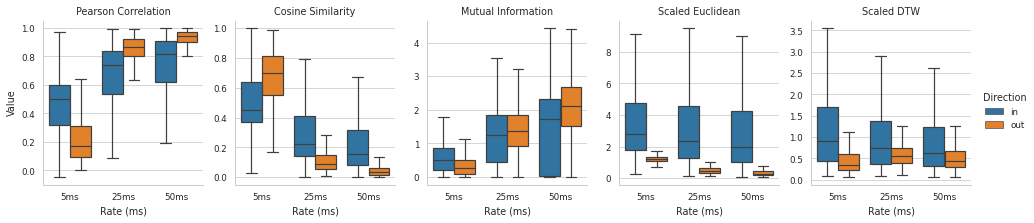

In [23]:
grid = sns.catplot(data=plot_data, x="rate", y="value", hue="Direction", col="metric", sharey=False, kind="box", height=3, aspect=0.9, showfliers=False)

for axis in grid.axes[0]:
    axis.set_xlabel("Rate (ms)")
    
grid.axes
grid.axes[0, 0].set_ylabel("Value")
grid.set_titles(col_template="{col_name}")

In [6]:
grid.savefig(plot_file, bbox_inches="tight")